In [1]:
#importing libraries
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
!pip install xgboost
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
#reading the given datafile
df=pd.read_csv(r'1804466.csv')
df.tail()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
49995,U001,0200780383,MEIJ llc,NaN,2020.0,1.930627e+09,2020-03-09,20200309,20200309,20200513.0,USD,RV,1.0,NaN,326.60,20200309.0,NAGD,1.930627e+09,1
49996,U001,0200881076,ALBERT associates,NaN,2020.0,1.930732e+09,2020-04-02,20200402,20200402,20200417.0,USD,RV,1.0,NaN,94406.39,20200402.0,NAA8,1.930732e+09,1
49997,U001,0200769623,WAL-MAR corp,NaN,2020.0,1.930781e+09,2020-04-13,20200413,20200413,20200428.0,USD,RV,1.0,NaN,72423.57,20200413.0,NAH4,1.930781e+09,1
49998,U001,0200416837,DEC trust,NaN,2020.0,1.930812e+09,2020-04-22,20200422,20200422,20200509.0,USD,RV,1.0,NaN,4923.77,20200416.0,NAM4,1.930812e+09,1
49999,U001,0200769623,WAL-MAR associates,NaN,2020.0,1.930611e+09,2020-03-06,20200306,20200306,20200321.0,USD,RV,1.0,NaN,19657.38,20200306.0,NAH4,1.930611e+09,1


### PRE-PROCESSING

In [3]:
#find the columns with the null values
df.isnull().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                 3646
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    5
isOpen                        0
dtype: int64

As we can see that the column area business is completely null so we will deop it

In [4]:
df.shape
df.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [5]:
#dropping the cloumn where all values are null
df.dropna(axis=1,how='all',inplace=True)
df.shape

(50000, 18)

In [6]:
#checking if any row is completely empty
s=df.dropna(axis=0,how='all')
s.shape

(50000, 18)

In [7]:
#checking the null values
df.isnull().sum()

business_code                0
cust_number                  0
name_customer                0
clear_date                3646
buisness_year                0
doc_id                       0
posting_date                 0
document_create_date         0
document_create_date.1       0
due_in_date                  0
invoice_currency             0
document type                0
posting_id                   0
total_open_amount            0
baseline_create_date         0
cust_payment_terms           0
invoice_id                   5
isOpen                       0
dtype: int64

In [8]:
#dropping the rows where invoice_id has null value
df.dropna(axis=0,subset=['invoice_id'],inplace=True)
df.shape

(49995, 18)

In [9]:
#checking null values again
df.isnull().sum()

business_code                0
cust_number                  0
name_customer                0
clear_date                3646
buisness_year                0
doc_id                       0
posting_date                 0
document_create_date         0
document_create_date.1       0
due_in_date                  0
invoice_currency             0
document type                0
posting_id                   0
total_open_amount            0
baseline_create_date         0
cust_payment_terms           0
invoice_id                   0
isOpen                       0
dtype: int64

In [10]:
#looking at our dataframe
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0100000222,SMITHFIE foundation,2019-05-20 00:00:00,2019.0,1.929285e+09,2019-05-09,20190508,20190509,20190524.0,USD,RV,1.0,26888.79,20190509.0,NAA8,1.929285e+09,0
1,CA02,0140104472,MARTIN,2019-03-27 00:00:00,2019.0,2.960531e+09,2019-02-26,20190226,20190226,20190318.0,CAD,RV,1.0,2963.10,20190308.0,CA10,2.960531e+09,0
2,CA02,0140104429,COSTCO foundation,2019-02-07 00:00:00,2019.0,2.960526e+09,2019-01-27,20190127,20190127,20190207.0,CAD,RV,1.0,5379.03,20190128.0,CA10,2.960526e+09,0
3,U001,0200418007,AM us,2020-01-29 00:00:00,2020.0,1.930384e+09,2020-01-14,20200110,20200114,20200129.0,USD,RV,1.0,83775.94,20200114.0,NAA8,1.930384e+09,0
4,U001,0200762301,C&S WH associates,2019-05-29 00:00:00,2019.0,1.929303e+09,2019-05-14,20190512,20190514,20190529.0,USD,RV,1.0,24936.23,20190514.0,NAC6,1.929303e+09,0


In [11]:
#converting clear_date into datetime format
df['clear_date']=pd.to_datetime(df['clear_date'],format='%Y-%m-%d %H:%M:%S')
df['clear_date'].head()

0   2019-05-20
1   2019-03-27
2   2019-02-07
3   2020-01-29
4   2019-05-29
Name: clear_date, dtype: datetime64[ns]

In [12]:
#converting posting_date into datetime format
df['posting_date']=pd.to_datetime(df['posting_date'],format='%Y-%m-%d')
df['posting_date'].head()

0   2019-05-09
1   2019-02-26
2   2019-01-27
3   2020-01-14
4   2019-05-14
Name: posting_date, dtype: datetime64[ns]

In [13]:
#converting due_in_date into datetime format
df['due_in_date']=pd.to_datetime(df['due_in_date'],format='%Y%m%d')
df['due_in_date'].head()

0   2019-05-24
1   2019-03-18
2   2019-02-07
3   2020-01-29
4   2019-05-29
Name: due_in_date, dtype: datetime64[ns]

In [14]:
#converting document_create_date.1 into datetime format
df['document_create_date.1']=pd.to_datetime(df['document_create_date.1'],format='%Y%m%d')
df['document_create_date.1'].head()

0   2019-05-09
1   2019-02-26
2   2019-01-27
3   2020-01-14
4   2019-05-14
Name: document_create_date.1, dtype: datetime64[ns]

In [15]:
#converting baseline_create_date into datetime format
df['baseline_create_date']=pd.to_datetime(df['baseline_create_date'],format='%Y%m%d')
df['baseline_create_date'].head()

0   2019-05-09
1   2019-03-08
2   2019-01-28
3   2020-01-14
4   2019-05-14
Name: baseline_create_date, dtype: datetime64[ns]

In [16]:
#checking the list of columns
df.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [17]:
#dropping constant features
constant_features = [
    feat for feat in df.columns if df[feat].nunique() == 1
]
df.drop(constant_features,axis=1,inplace=True)
df.shape

(49995, 16)

In [18]:
#checking again to see which columns were dropped
df.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms',
       'invoice_id', 'isOpen'],
      dtype='object')

As documnet_type and posting_id were constant columns they were dropped

In [19]:
#function of finding duplicated columns
def dropu(df):
    duplicatecolumns=set()
    for x in range(df.shape[1]):
        col1=df.iloc[:,x]
        for y in range(x+1,df.shape[1]):
            col2=df.iloc[:,y]
            if col1.equals(col2):
                duplicatecolumns.add(df.columns.values[x])
    return list(duplicatecolumns)

We could use the inbuilt funcion to drop duplicates as it was taking very long as our dataset has many rows and it was computationally expensive

In [20]:
#calling the function and finding the duplicate columns
dr=dropu(df)
dr

['posting_date', 'doc_id']

In [21]:
#dropping the duplicated columns
df.drop(columns=dr,inplace=True)

In [22]:
df.shape

(49995, 14)

we see inconsistency between document_create_date and document_create_date.1, so we drop document_create_date

In [23]:
#dropping the column document_create_date
df.drop(columns=['document_create_date'],inplace=True)

In [24]:
#checking the uniqueness of values in invoice_id
df.invoice_id.nunique()

49995

In [25]:
#as all the values are unique it is not usefull  for our model hence dropping them
df.drop(columns=['invoice_id'],inplace=True)

In [26]:
#checking our dataframe
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
0,U001,0100000222,SMITHFIE foundation,2019-05-20,2019.0,2019-05-09,2019-05-24,USD,26888.79,2019-05-09,NAA8,0
1,CA02,0140104472,MARTIN,2019-03-27,2019.0,2019-02-26,2019-03-18,CAD,2963.10,2019-03-08,CA10,0
2,CA02,0140104429,COSTCO foundation,2019-02-07,2019.0,2019-01-27,2019-02-07,CAD,5379.03,2019-01-28,CA10,0
3,U001,0200418007,AM us,2020-01-29,2020.0,2020-01-14,2020-01-29,USD,83775.94,2020-01-14,NAA8,0
4,U001,0200762301,C&S WH associates,2019-05-29,2019.0,2019-05-14,2019-05-29,USD,24936.23,2019-05-14,NAC6,0


In [27]:
#finding the delay which is our target variable
df['Delay']=df['clear_date']-df['due_in_date']

In [28]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,isOpen,Delay
0,U001,0100000222,SMITHFIE foundation,2019-05-20,2019.0,2019-05-09,2019-05-24,USD,26888.79,2019-05-09,NAA8,0,-4 days
1,CA02,0140104472,MARTIN,2019-03-27,2019.0,2019-02-26,2019-03-18,CAD,2963.10,2019-03-08,CA10,0,9 days
2,CA02,0140104429,COSTCO foundation,2019-02-07,2019.0,2019-01-27,2019-02-07,CAD,5379.03,2019-01-28,CA10,0,0 days
3,U001,0200418007,AM us,2020-01-29,2020.0,2020-01-14,2020-01-29,USD,83775.94,2020-01-14,NAA8,0,0 days
4,U001,0200762301,C&S WH associates,2019-05-29,2019.0,2019-05-14,2019-05-29,USD,24936.23,2019-05-14,NAC6,0,0 days


In [29]:
#sorting the dataset on the basis of document_create_data.1
df.sort_values(by='document_create_date.1',inplace=True)

In [30]:
#checking if the invoice was cleared before the due date
df.Delay[df.Delay.dt.days<0].count()

17012

In [31]:
#using lambda and apply to cap the negative values to zero
df['Delay']=df.Delay.dt.days.apply(lambda x: 0 if x<0 else x)

In [32]:
#chceking again if we have any negative delay values
df.Delay[df.Delay<0].count()

0

In [33]:
#sorting the dataset on the basis of document_create_data.1
df.sort_values(by='document_create_date.1',inplace=True)

In [34]:
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,isOpen,Delay
7034,U001,0200769623,WAL-MAR corporation,2019-01-09,2019.0,2018-12-30,2019-01-14,USD,14599.04,2018-12-30,NAH4,0,0.0
18002,U001,0200769623,WAL-MAR,2019-01-09,2019.0,2018-12-30,2019-01-14,USD,4361.22,2018-12-30,NAH4,0,0.0
34168,U001,0200769623,WAL-MAR systems,2019-01-09,2019.0,2018-12-30,2019-01-14,USD,20173.91,2018-12-30,NAH4,0,0.0
20162,U001,0200101621,TRA us,2019-01-25,2019.0,2018-12-30,2019-01-14,USD,47019.96,2018-12-30,NAA8,0,11.0
43956,U001,0200769623,WAL-MAR corporation,2019-01-09,2019.0,2018-12-30,2019-01-14,USD,7497.67,2018-12-30,NAH4,0,0.0


### SPLITTING DATA

In [35]:
#storing all the null values of cleardate in test_set as we have to predict them
test_set=df[df.clear_date.isnull()].reset_index()

In [36]:
#dropping the extra index column made while reseting index
test_set.drop(columns='index',inplace=True)


In [37]:
ts=test_set.copy()

In [38]:
test_set.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,isOpen,Delay
0,CA02,0140104240,FEDER associates,NaT,2020.0,2020-02-27,2020-03-10,CAD,8280.91,2020-02-29,CA10,1,NaN
1,U001,0100021540,MASTER,NaT,2020.0,2020-02-27,2020-03-08,USD,57921.54,2020-02-27,NA10,1,NaN
2,U001,0200759878,SA,NaT,2020.0,2020-02-27,2020-03-13,USD,31552.06,2020-02-27,NAH4,1,NaN
3,U001,0200769623,WAL-MAR corp,NaT,2020.0,2020-02-27,2020-03-13,USD,14947.08,2020-02-27,NAH4,1,NaN
4,U001,0200759878,SA llc,NaT,2020.0,2020-02-27,2020-03-13,USD,8614.36,2020-02-27,NAH4,1,NaN


In [39]:
#dropping the null values of clear_date from our dataset and then checking for null values in 
df.dropna(subset=['clear_date'],inplace=True)
df.isnull().sum()

business_code             0
cust_number               0
name_customer             0
clear_date                0
buisness_year             0
document_create_date.1    0
due_in_date               0
invoice_currency          0
total_open_amount         0
baseline_create_date      0
cust_payment_terms        0
isOpen                    0
Delay                     0
dtype: int64

In [40]:
df.shape

(46349, 13)

In [41]:
#splitting the dataset in 70% and 30% as the training data is gonna be 70%
df_train,df_val=train_test_split(df,test_size=.30,shuffle=False,random_state=9)

In [42]:
#checking if the splitting was done correctly
df_train.shape,df_val.shape

((32444, 13), (13905, 13))

In [43]:
#splitting the rest 30% in 50:50 one for hyperparameter tuning and the other for testing 
df_val1,df_val2=train_test_split(df_val,test_size=.50,shuffle=False,random_state=2)

In [44]:
#chceking their shape again to see if it was done correctly
df_val1.shape,df_val2.shape

((6952, 13), (6953, 13))

### EDA

In [45]:
#counting the no of unique values occur in business_code
df_train.business_code.value_counts()

U001    29222
CA02     2626
U013      467
U002      116
U005       10
U007        3
Name: business_code, dtype: int64

As we can see that there only 6 unique business codes so we can use some encoding on it during feature engineering

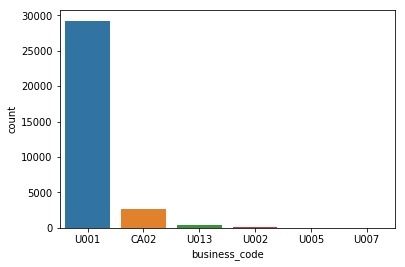

In [46]:
#plotting those values in a graph using countplot
sns.countplot(x = df_train['business_code'])

In [47]:
#counting the no of unique values occur in cust_number
df_train.cust_number.value_counts()

0200769623    6958
0200726979    1168
0200762301     991
0200759878     799
200769623      714
0200794332     704
0200744019     622
0200772670     581
0200705742     522
CCU013         476
0200707822     455
CCCA02         384
0140106408     352
0200418007     342
0140104409     325
0200780383     286
0140104429     278
0100031704     270
0200803720     264
0200761734     250
0200416837     248
0200230690     244
0200799367     243
0200706844     226
0200936373     225
0140105686     219
0200353024     219
0200772595     216
0200793568     208
0200974851     201
              ... 
0200687594       1
0100052151       1
200769556        1
0100056786       1
0140104729       1
0200058206       1
0200686200       1
0140103415       1
0200067753       1
100012991        1
0200739074       1
0100030934       1
0200754142       1
0100028237       1
0200397176       1
0200481695       1
0100043963       1
100027362        1
100030443        1
100035306        1
100047417        1
100036486   

In [48]:
#counting the no of unique values occur in name_customer
df_train.name_customer.value_counts()

WAL-MAR co              754
WAL-MAR us              711
WAL-MAR in              711
WAL-MAR corp            710
WAL-MAR systems         702
WAL-MAR associates      697
WAL-MAR                 687
WAL-MAR corporation     682
WAL-MAR llc             681
WAL-MAR trust           674
WAL-MAR foundation      663
BJ'S  in                136
BJ'S  corporation       128
BJ'S  llc               121
BJ'S  us                120
BJ'S  foundation        113
BJ'S  trust             113
BJ'S  systems           112
BJ'S  co                110
C&S WH systems          109
SA corp                 109
C&S WH corp             106
C&S WH corporation      105
BJ'S                    105
C&S WH in               105
BJ'S  corp              104
BJ'S  associates        104
SA us                   103
SA systems              103
SA foundation           102
                       ... 
KITCH corp                1
RESTO                     1
SING associates           1
CUSTOMI systems           1
CJR WH associates   

After looking at the data we find that all the sub branches of a company have the same customer number.For ex all the companies under WAL-MAR have the same customer number but different names. So we can drop the customer name column as encoding it is also going to be difficult

In [49]:
#checking how many customers only interacted with us once
(df_train.name_customer.value_counts()==1).count()

3630

In [50]:
#checking the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46349 entries, 7034 to 24662
Data columns (total 13 columns):
business_code             46349 non-null object
cust_number               46349 non-null object
name_customer             46349 non-null object
clear_date                46349 non-null datetime64[ns]
buisness_year             46349 non-null float64
document_create_date.1    46349 non-null datetime64[ns]
due_in_date               46349 non-null datetime64[ns]
invoice_currency          46349 non-null object
total_open_amount         46349 non-null float64
baseline_create_date      46349 non-null datetime64[ns]
cust_payment_terms        46349 non-null object
isOpen                    46349 non-null int64
Delay                     46349 non-null float64
dtypes: datetime64[ns](4), float64(3), int64(1), object(5)
memory usage: 5.0+ MB


In [51]:
#counting the no of unique values occur in isOpen
df_train.isOpen.value_counts()

0    32444
Name: isOpen, dtype: int64

As we can see all the values where clear_date is available the isOpen column is 0 therefore we can conclude that where the clear_date is null the invoice has not been cleared hence this wont be contributing during the model

In [52]:
#dropping the isOpen column
df_train.drop(columns='isOpen',inplace=True)

C:\Users\KIIT\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


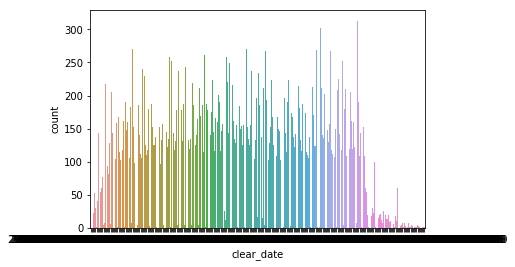

In [53]:
#plotting the clear_date using countplot as we sorted the data according to date so we can check if there is any relation between them
sns.countplot(x = df_train['clear_date'])

In [54]:
df_train.shape
#checking the shape

(32444, 12)

In [55]:
df_train.total_open_amount.describe()
#decribing the total open amount that is checking its mean mode etc

count     32444.000000
mean      31569.695381
std       39705.654852
min           2.120000
25%        4383.300000
50%       16710.665000
75%       45640.430000
max      895315.200000
Name: total_open_amount, dtype: float64

In [56]:
#binning the total open amount
amount_bins = [0,5000,10000,50000,100000,900000]
open_amount_bin = pd.cut(df_train.total_open_amount, bins = amount_bins)

In [57]:
#checking to see how much each bin contains
open_amount_bin.value_counts()

(10000, 50000]      13288
(0, 5000]            8609
(50000, 100000]      5177
(5000, 10000]        3258
(100000, 900000]     2112
Name: total_open_amount, dtype: int64

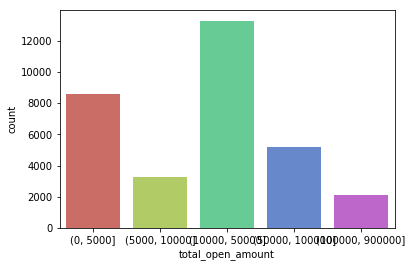

In [58]:
#plotting the bins for better visualisation
sns.countplot(x=open_amount_bin, palette="hls")

Here we can see although the last bin is very big the no of transaction of that amount are the least. Also the total_open amount between 10000-50000 is the largest so that is amount where max transations takes place

In [59]:
#chceking the for how many values baseline_create_date is different from documnet create date
baseline_set = df_train.loc[df_train["document_create_date.1"]!=df_train["baseline_create_date"]]
baseline_set.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,Delay
8384,CA02,0140105847,GORDON F co,2019-01-21,2019.0,2018-12-30,2019-01-10,CAD,795.20,2018-12-31,CA10,11.0
2985,CA02,0140105686,SYSC corporation,2019-01-17,2019.0,2018-12-31,2019-01-13,CAD,10704.22,2019-01-03,CA10,4.0
26587,CA02,0140104429,COSTCO trust,2019-01-18,2019.0,2018-12-31,2019-01-13,CAD,1019.54,2019-01-03,CA10,5.0
9327,CA02,0140105847,GORDON F foundation,2019-01-14,2019.0,2018-12-31,2019-01-12,CAD,5345.00,2019-01-02,CA10,2.0
8786,CA02,0140104429,COSTCO foundation,2019-01-18,2019.0,2018-12-31,2019-01-19,CAD,8938.18,2019-01-09,CA10,0.0


There are just above 3500 values where they are not the same. And if we see in the first glance it looks like if the company is canadian there is a delay in filing the document and creating an invoice. So we can drop it as it is mostly same as document create date

In [60]:
#findng the correlation
df_train.corr()

,buisness_year,total_open_amount,Delay
buisness_year,NaN,NaN,NaN
total_open_amount,NaN,1.000000,-0.047061
Delay,NaN,-0.047061,1.000000


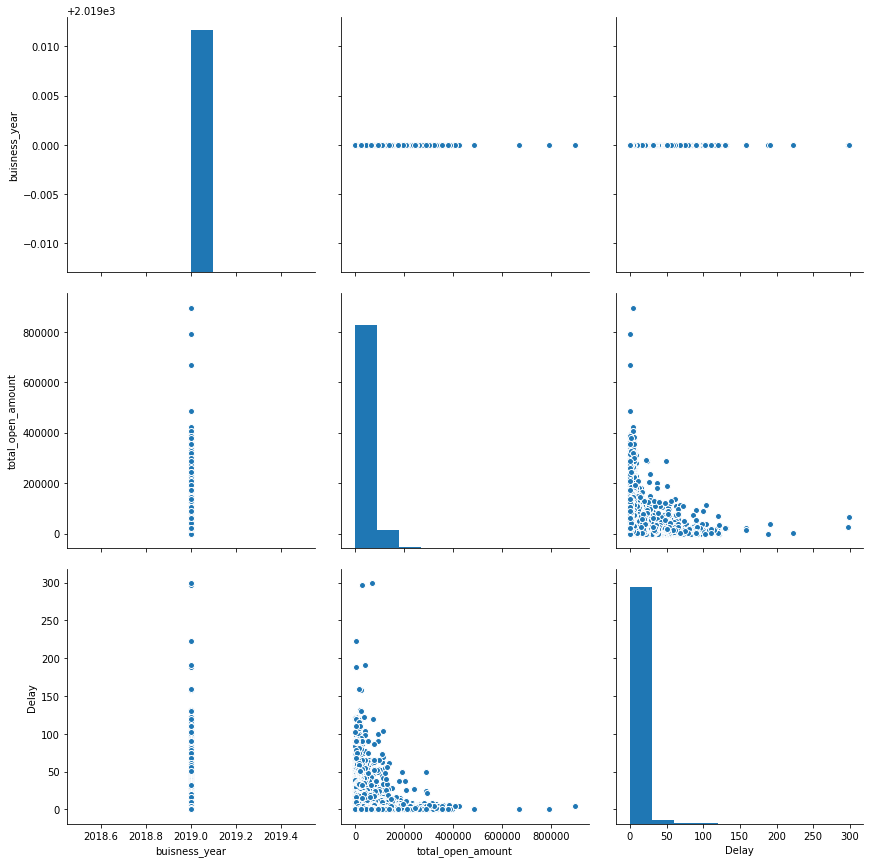

In [61]:
#we plotted the numeric values against all numeric values so see visualise the correlation better
sns.pairplot(df_train, size=4)

As we can see from the graphs above that total open amount increases the delay decreases and for some values of total open amount the delay is very big those can be considered as outliers.
The conclusion we derived from the graph is hence proven here by the negative coorelation.

In [62]:
#grouping by business code and invoice currency to understand the relation
df_train.groupby("business_code").invoice_currency.value_counts()

business_code  invoice_currency
CA02           CAD                  2626
U001           USD                 29222
U002           USD                   116
U005           USD                    10
U007           USD                     3
U013           USD                   467
Name: invoice_currency, dtype: int64

As we can see the most of the transactions are made in USD and even if we change the CAD to USD it wont be making much of a difference hence we can drop invoice currency. Also from the above table we see that business code first letter decribes in which currency the transaction took place and hence we can either keep invoice currency or business code. I believe dropping the business code will be better as if we perform one hot encoding on business code it will result in 6 different columns while if we do the same on invoice currency it will give us only 2 diff columns which will be easier to handle

In [63]:
#grouping by cust_number and total_open_amount
df_train.groupby('cust_number').total_open_amount.mean()

cust_number
0100000048     94357.476667
0100000051     35846.906667
0100000158     39144.040000
0100000161      1806.080000
0100000217     23027.800000
0100000222     22820.273333
0100000533       625.000000
0100000933      3602.440000
0100001196     16897.136545
0100001222     12019.895000
0100001452      7822.316667
0100001659      9145.125000
0100003615      2908.680000
0100003908      3135.020000
0100004335     54586.620000
0100004536     33642.285385
0100004744     52593.620000
0100005721     32810.603333
0100005765     38730.500000
0100006176     21312.360000
0100006311     21153.823333
0100006671     79308.000000
0100006823     16432.200000
0100006871      5098.450000
0100007796      1754.650000
0100007916     10588.125714
0100008001     18705.425000
0100008347     13535.120000
0100009152      6530.850000
0100009866     13138.400000
                  ...      
200920735      75027.476000
200936373      60218.727333
200942148      16124.400000
200956366       9652.000000
20095876

In [64]:
#extracting the month of the document create date and storing it in a new column
df_train['document_create_month']=df_train['document_create_date.1'].dt.month

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
#grouping by document_create_month and Delay to find the mean delay
k=df_train.groupby('document_create_month')['Delay'].mean()

In [66]:
k

document_create_month
1     3.324077
2     3.425937
3     3.111698
4     3.091660
5     2.850306
6     3.349564
7     2.679240
8     2.573059
9     2.759545
10    3.432836
12    2.257143
Name: Delay, dtype: float64

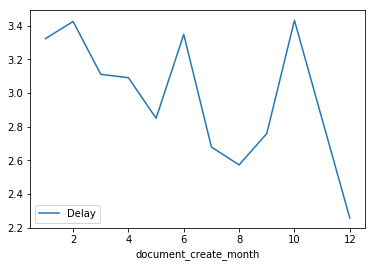

In [67]:
k.plot(legend=True)
#plotting mean delay against create month

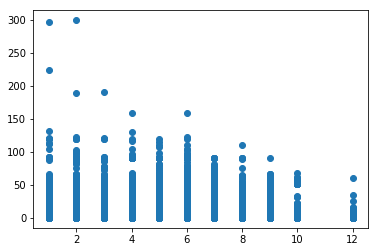

In [68]:
#plotting the delay itself against the create month using scatter plot
plt.scatter(df_train.document_create_month,df_train.Delay)

We see that mostly the delay varies from 0 to 130 days only a few delays are there which have a value around 300 days therefore they can be considered as outliers

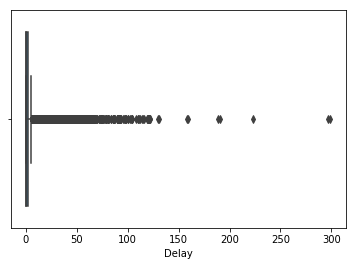

In [69]:
sns.boxplot(x=df_train.Delay)

The same conclusion can be derived from the box plot

In [70]:
ko=df_train['due_in_date'].dt.month
#extracting the month of due date

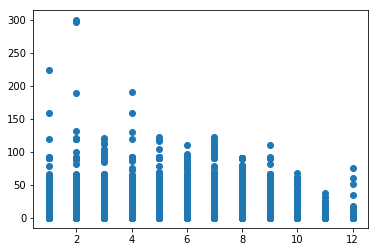

In [71]:
#plotting the delay itself against the due month using scatter plot
plt.scatter(ko,df_train.Delay)


In [72]:
df_train.info()
#checking the info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32444 entries, 7034 to 7172
Data columns (total 13 columns):
business_code             32444 non-null object
cust_number               32444 non-null object
name_customer             32444 non-null object
clear_date                32444 non-null datetime64[ns]
buisness_year             32444 non-null float64
document_create_date.1    32444 non-null datetime64[ns]
due_in_date               32444 non-null datetime64[ns]
invoice_currency          32444 non-null object
total_open_amount         32444 non-null float64
baseline_create_date      32444 non-null datetime64[ns]
cust_payment_terms        32444 non-null object
Delay                     32444 non-null float64
document_create_month     32444 non-null int64
dtypes: datetime64[ns](4), float64(3), int64(1), object(5)
memory usage: 4.7+ MB


### Feature Engineering

In [73]:
#applying one hot encoding but simply as only two values are available in invoice_currency
df_train['invoice_currency']=np.where(df_train['invoice_currency']=='USD',1,0)

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
#finding the value counts of invoice_currency to check how many values are there in each curency
df_train.invoice_currency.value_counts()

1    29818
0     2626
Name: invoice_currency, dtype: int64

In [75]:
#performing label encoding on the customer number column
df_train['cust_number'] = df_train['cust_number'].str.extract('(\d+)')
df_train['cust_number'] =df_train['cust_number'].astype(str)
df_train['cust_number'] =df_train['cust_number'].astype(int)

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

While grouping by cust_number with total open amount we saw that some of the values were a combination of string as well as numbers and we cannot use string in modelling so we extract just the numbers in such rows

In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32444 entries, 7034 to 7172
Data columns (total 13 columns):
business_code             32444 non-null object
cust_number               32444 non-null int32
name_customer             32444 non-null object
clear_date                32444 non-null datetime64[ns]
buisness_year             32444 non-null float64
document_create_date.1    32444 non-null datetime64[ns]
due_in_date               32444 non-null datetime64[ns]
invoice_currency          32444 non-null int32
total_open_amount         32444 non-null float64
baseline_create_date      32444 non-null datetime64[ns]
cust_payment_terms        32444 non-null object
Delay                     32444 non-null float64
document_create_month     32444 non-null int64
dtypes: datetime64[ns](4), float64(3), int32(2), int64(1), object(3)
memory usage: 4.5+ MB


Now we can see that cust_number is also an integer value

In [77]:
df_train.drop(columns=['business_code','name_customer','invoice_currency','cust_payment_terms','buisness_year','baseline_create_date'],inplace=True)
#we are dropping certain columns

C:\Users\KIIT\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


We have also dropped invoice currency as the proportion of CAD TO USD is very less so it wont be much help during the modelling

In [78]:
#having a look at the data now
df_train.head()

,cust_number,clear_date,document_create_date.1,due_in_date,total_open_amount,Delay,document_create_month
7034,200769623,2019-01-09,2018-12-30,2019-01-14,14599.04,0.0,12
18002,200769623,2019-01-09,2018-12-30,2019-01-14,4361.22,0.0,12
34168,200769623,2019-01-09,2018-12-30,2019-01-14,20173.91,0.0,12
20162,200101621,2019-01-25,2018-12-30,2019-01-14,47019.96,11.0,12
43956,200769623,2019-01-09,2018-12-30,2019-01-14,7497.67,0.0,12


In [79]:
df_train.shape

(32444, 7)

In [80]:
#extracting the month and date from the document create date and due in date
df_train['document_create_day']=df_train['document_create_date.1'].dt.day
df_train['due_in_month']=df_train['due_in_date'].dt.month
df_train['due_in_day']=df_train['due_in_date'].dt.day
#we have not extracted document create month as we already did that above

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [81]:
#dropping those columns as we have already extracted those features
df_train.drop(columns=['clear_date','document_create_date.1','due_in_date'],inplace=True)

C:\Users\KIIT\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [82]:
#seeing the dataset now
df_train.head()

,cust_number,total_open_amount,Delay,document_create_month,document_create_day,due_in_month,due_in_day
7034,200769623,14599.04,0.0,12,30,1,14
18002,200769623,4361.22,0.0,12,30,1,14
34168,200769623,20173.91,0.0,12,30,1,14
20162,200101621,47019.96,11.0,12,30,1,14
43956,200769623,7497.67,0.0,12,30,1,14


Now we will do whatever we have done in train set on the other 3 set as well

In [83]:
#dropping the isOpen column
df_val1.drop(columns='isOpen',inplace=True)
df_val2.drop(columns='isOpen',inplace=True)
test_set.drop(columns='isOpen',inplace=True)

C:\Users\KIIT\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [84]:
#extracting the document craete month
df_val1['document_create_month']=df_val1['document_create_date.1'].dt.month
df_val2['document_create_month']=df_val2['document_create_date.1'].dt.month
test_set['document_create_month']=test_set['document_create_date.1'].dt.month

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
#encoding the cust_number
df_val1['cust_number'] = df_val1['cust_number'].str.extract('(\d+)')
df_val1['cust_number'] =df_val1['cust_number'].astype(str)
df_val1['cust_number'] =df_val1['cust_number'].astype(int)

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [86]:
df_val2['cust_number'] = df_val2['cust_number'].str.extract('(\d+)')
df_val2['cust_number'] =df_val2['cust_number'].astype(str)
df_val2['cust_number'] =df_val2['cust_number'].astype(int)

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [87]:
test_set['cust_number'] = test_set['cust_number'].str.extract('(\d+)')
test_set['cust_number'] =test_set['cust_number'].astype(str)
test_set['cust_number'] =test_set['cust_number'].astype(int)

In [88]:
#dropping the columns
df_val1.drop(columns=['business_code','name_customer','invoice_currency','cust_payment_terms','buisness_year','baseline_create_date'],inplace=True)
df_val2.drop(columns=['business_code','name_customer','invoice_currency','cust_payment_terms','buisness_year','baseline_create_date'],inplace=True)
test_set.drop(columns=['business_code','name_customer','invoice_currency','cust_payment_terms','buisness_year','baseline_create_date'],inplace=True)

C:\Users\KIIT\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [89]:
#extracting month and day from document create date and due date
df_val1['document_create_day']=df_val1['document_create_date.1'].dt.day
df_val1['due_in_month']=df_val1['due_in_date'].dt.month
df_val1['due_in_day']=df_val1['due_in_date'].dt.day
df_val2['document_create_day']=df_val2['document_create_date.1'].dt.day
df_val2['due_in_month']=df_val2['due_in_date'].dt.month
df_val2['due_in_day']=df_val2['due_in_date'].dt.day
test_set['document_create_day']=test_set['document_create_date.1'].dt.day
test_set['due_in_month']=test_set['due_in_date'].dt.month
test_set['due_in_day']=test_set['due_in_date'].dt.day

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [90]:
#dropping documnet create and due in date column
df_val1.drop(columns=['clear_date','document_create_date.1','due_in_date'],inplace=True)
df_val2.drop(columns=['clear_date','document_create_date.1','due_in_date'],inplace=True)
test_set.drop(columns=['clear_date','document_create_date.1','due_in_date'],inplace=True)

C:\Users\KIIT\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### FEATURE SELECTION

In [91]:
#splitting the data into which is the train and what has to be predicted
x_train=df_train.drop(["Delay"], axis=1)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32444 entries, 7034 to 7172
Data columns (total 6 columns):
cust_number              32444 non-null int32
total_open_amount        32444 non-null float64
document_create_month    32444 non-null int64
document_create_day      32444 non-null int64
due_in_month             32444 non-null int64
due_in_day               32444 non-null int64
dtypes: float64(1), int32(1), int64(4)
memory usage: 2.9 MB


In [92]:
#the prediction column
x_test=df_train['Delay']
x_test.head()

7034      0.0
18002     0.0
34168     0.0
20162    11.0
43956     0.0
Name: Delay, dtype: float64

In [93]:
#same for val1
val1_train = df_val1.drop(["Delay"], axis=1)
val1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6952 entries, 28302 to 5791
Data columns (total 6 columns):
cust_number              6952 non-null int32
total_open_amount        6952 non-null float64
document_create_month    6952 non-null int64
document_create_day      6952 non-null int64
due_in_month             6952 non-null int64
due_in_day               6952 non-null int64
dtypes: float64(1), int32(1), int64(4)
memory usage: 353.0 KB


In [94]:
val1_test=df_val1['Delay']
val1_test.head()

28302     0.0
7973     50.0
40309     1.0
1360      0.0
41157     1.0
Name: Delay, dtype: float64

In [95]:
#and val2
val2_train = df_val2.drop(["Delay"], axis=1)
val2_train.head()

,cust_number,total_open_amount,document_create_month,document_create_day,due_in_month,due_in_day
18648,200769623,12666.48,12,9,12,24
10414,200769623,44322.52,12,9,12,24
28136,200793088,148077.38,12,9,12,24
40522,200780383,2984.10,12,9,12,24
26166,200707822,72108.50,12,9,12,24


In [96]:
val2_test=df_val2['Delay']
val2_test.head()

18648    0.0
10414    0.0
28136    0.0
40522    0.0
26166    0.0
Name: Delay, dtype: float64

In [97]:
#and for test set
y_train = test_set.drop(["Delay"], axis=1)
y_train.head()

,cust_number,total_open_amount,document_create_month,document_create_day,due_in_month,due_in_day
0,140104240,8280.91,2,27,3,10
1,100021540,57921.54,2,27,3,8
2,200759878,31552.06,2,27,3,13
3,200769623,14947.08,2,27,3,13
4,200759878,8614.36,2,27,3,13


In [98]:
y_test=test_set['Delay']
y_test.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Delay, dtype: float64

#### Filter Method

In [99]:
#Passing a value of zero for the parameter will filter all the features with zero variance
constant_filter = VarianceThreshold(threshold=0)
#we need to simply apply this filter to our training set as shown in the following example
constant_filter.fit(x_train)
#the number of non-constant features.
len(x_train.columns[constant_filter.get_support()])

6

In [100]:
#the no of constant columns
constant_columns = [column for column in x_train.columns
                    if column not in x_train.columns[constant_filter.get_support()]]

print(len(constant_columns))

0


In [101]:
#finding duplicate columns
x_train_T = x_train.T
# print the number of duplicated features
print(x_train_T.duplicated().sum())
# select the duplicated features columns names
duplicated_columns = x_train_T[x_train_T.duplicated()].index.values

0


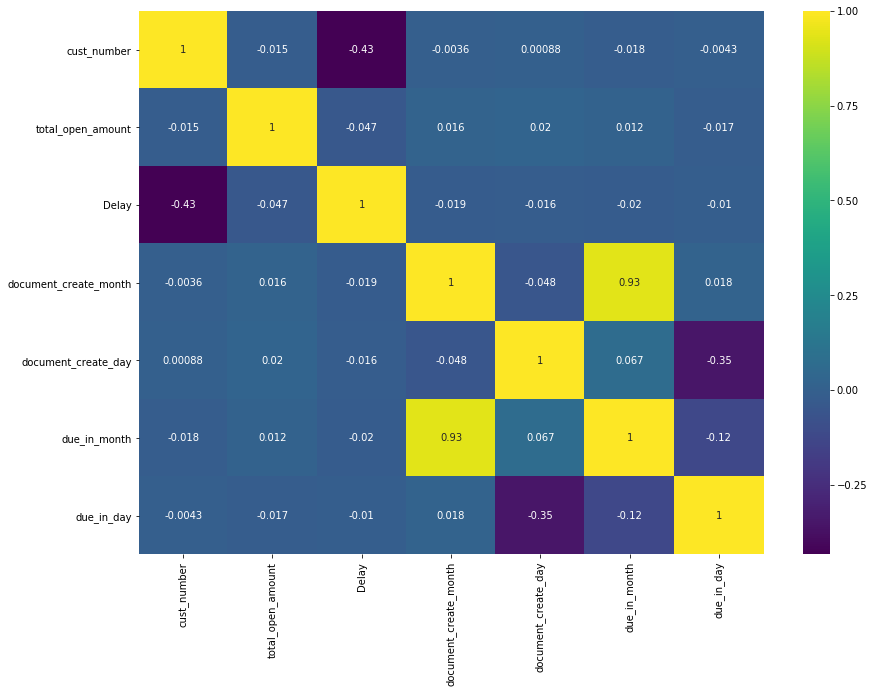

In [102]:
#finding highly correlated columns
plt.figure(figsize=(14,10))
cor = df_train.corr()
sns.heatmap(cor,cmap = 'viridis',annot=True)

In [103]:
def handling_correlation(df,threshold=0.8):
    # creating set to hold the correlated features
    corr_features = set()
    # create the correlation matrix (default to pearson)
    corr_matrix = df.corr()
    #code for selecting all correleated features
    for i in range(len(corr_matrix .columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >threshold:
                colname = corr_matrix.columns[i]
                corr_features.add(colname)
    return list(corr_features)

In [104]:
#calling the function
handling_correlation(x_train.copy(),0.85)

['due_in_month']

In [105]:
#dropping that column
x_train=x_train.drop(['due_in_month'],axis=1)

In [106]:
val1_train=val1_train.drop(['due_in_month'],axis=1)
val2_train=val2_train.drop(['due_in_month'],axis=1)
y_train=y_train.drop(['due_in_month'],axis=1)

### FITTING INTO MODEL

In [107]:
#first using random forest
clf = RandomForestRegressor()
clf.fit(x_train, x_test)

# Predicting the Validation Set Results
predicted = clf.predict(val1_train)

In [108]:
print("Mean absolute error =", round(sm.mean_absolute_error(val1_test, predicted), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(val1_test, predicted), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(val1_test, predicted), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(val1_test, predicted), 2)) 
print("R2 score =", round(sm.r2_score(val1_test, predicted), 2))
print("Accuracy= ", clf.score(val1_train,val1_test))

Mean absolute error = 2.49
Mean squared error = 26.59
Median absolute error = 1.1
Explain variance score = 0.17
R2 score = 0.13
Accuracy=  0.12969510824536534


In [109]:
#using decision tree regressor
clf2 = DecisionTreeRegressor()
clf2.fit(x_train, x_test)

# Predicting the Validation Set Results
predicted2 = clf2.predict(val1_train)

In [110]:
print("Mean absolute error =", round(sm.mean_absolute_error(val1_test, predicted2), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(val1_test, predicted2), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(val1_test, predicted2), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(val1_test, predicted2), 2)) 
print("R2 score =", round(sm.r2_score(val1_test, predicted2), 2))
print("Accuracy= ", clf2.score(val1_train,val1_test))

Mean absolute error = 2.61
Mean squared error = 46.91
Median absolute error = 1.0
Explain variance score = -0.51
R2 score = -0.54
Accuracy=  -0.5352745775752674


In [111]:
#using XGBbooster
clf3 = xgb.XGBRegressor()
clf3.fit(x_train, x_test)

# Predicting the Validation Set Results
predicted3 = clf3.predict(val1_train)

In [112]:
print("Mean absolute error =", round(sm.mean_absolute_error(val1_test, predicted3), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(val1_test, predicted3), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(val1_test, predicted3), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(val1_test, predicted3), 2)) 
print("R2 score =", round(sm.r2_score(val1_test, predicted3), 2))
print("Accuracy= ", clf3.score(val1_train,val1_test))

Mean absolute error = 2.11
Mean squared error = 20.28
Median absolute error = 1.08
Explain variance score = 0.35
R2 score = 0.34
Accuracy=  0.33616686662135087


In [ ]:
We will use XGBregressor as it gives us the best result

#### HYPERPARAMETER TUNING

In [113]:
#defining the parameters
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [114]:
#using randomized searchCV
random_search=RandomizedSearchCV(clf3,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [115]:
random_search.fit(x_train, x_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   27.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   29.7s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, miss... scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None),
          fit_params=None, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'min_child_weight': [1, 3, 5, 7], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.3, 0.4, 0.5, 0.7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=3)

In [116]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0.0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.2, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=8, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [117]:
clf3=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=3, monotone_constraints='()',
       n_estimators=100, n_jobs=8, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)
clf3.fit(x_train,x_test)
predicted=clf3.predict(val2_train)

In [118]:
print("Mean absolute error =", round(sm.mean_absolute_error(val2_test, predicted), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(val2_test, predicted), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(val2_test, predicted), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(val2_test, predicted), 2)) 
print("R2 score =", round(sm.r2_score(val2_test, predicted), 2))
print("Accuracy= ", clf3.score(val2_train,val2_test))

Mean absolute error = 2.34
Mean squared error = 32.25
Median absolute error = 1.42
Explain variance score = 0.5
R2 score = 0.5
Accuracy=  0.498030787734714


In [119]:
predicted1=clf3.predict(y_train)
#predicting the delay in test set

In [120]:
predicted1=np.around(predicted1)
predicted1.astype(int)
#rounding it off as days cannot be in decimal

array([ 4,  4,  2, ...,  4,  1, 17])

In [121]:
#creating a new dataframe
Col=pd.DataFrame()

In [122]:
#appending the delay predicted column in it
Delay=[]
for x in predicted1:
    Delay.append(pd.Timedelta(days=x))
Col['Delay'] = Delay
Col

,Delay
0,4 days
1,4 days
2,2 days
3,1 days
4,2 days
5,2 days
6,1 days
7,1 days
8,37 days
9,5 days


In [123]:
#finding the clear_date
Col['clear_date'] = ts['due_in_date']+Col['Delay']
Col

,Delay,clear_date
0,4 days,2020-03-14
1,4 days,2020-03-12
2,2 days,2020-03-15
3,1 days,2020-03-14
4,2 days,2020-03-15
5,2 days,2020-03-15
6,1 days,2020-04-02
7,1 days,2020-03-14
8,37 days,2020-04-04
9,5 days,2020-03-13


In [124]:
# Creating the Aging Bucket
aging_bucket = []
for x in predicted1:
    if x<=15:
        aging_bucket.append("0-15days")
    elif x<=30:
        aging_bucket.append("16-30days")
    elif x<=45:
        aging_bucket.append("31-45days")
    elif x<=60:
        aging_bucket.append("46-60days")
    else:
        aging_bucket.append("Greater than 60 days")
Col['Aging Bucket']= aging_bucket
Col.drop(['Delay'],axis=1,inplace=True)
Col

,clear_date,Aging Bucket
0,2020-03-14,0-15days
1,2020-03-12,0-15days
2,2020-03-15,0-15days
3,2020-03-14,0-15days
4,2020-03-15,0-15days
5,2020-03-15,0-15days
6,2020-04-02,0-15days
7,2020-03-14,0-15days
8,2020-04-04,31-45days
9,2020-03-13,0-15days
